In [ ]:
!unzip Humor,Hist,Media,Food.zip

In [54]:
import pickle
import nltk
import time
import string
import glob
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import heapq
import numpy as np
import matplotlib.pyplot as plt
import math
from math import exp, sqrt, pi
from scipy import spatial
import copy

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [55]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
lemmatizer = nltk.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
stopwords = nltk.corpus.stopwords.words()

# Q1

## a)

In [56]:
def preprocess(line):
  '''
  Preprocess the data
    - Lowercase
    - Remove Extra Spaces
    - Lemmatize using WordNetLemmatizer()
    - Tokenize using RegexpTokenizer()
    - Remove stopwords
  '''
  line = " ".join(line.lower().split()) #lowercase and remove extra spaces
  #line = line.apply(lambda x: nltk.word_tokenize(x)) #tokenize
  line = [word for word in line.split() if not word in stopwords] #remove stopwords
  line = [lemmatizer.lemmatize(word) for word in line] #lemmatize
  line = tokenizer.tokenize(" ".join(line)) #tokenize
  return set(line)

data_dict = {}

for n, filee in enumerate(glob.glob('Humor,Hist,Media,Food/*')):
  with open(filee, "r", encoding='windows-1254', errors='ignore') as fp:
    fp = fp.read()
    word_set = preprocess(fp)
    data_dict[filee.split("/")[-1]] = word_set

#save the index
with open('word_index.pkl', 'wb') as fp:
    pickle.dump(data_dict, fp)

In [57]:
with open('word_index.pkl', 'rb') as fp:
    data_dict = pickle.load(fp)

In [58]:
def preprocessQuery(line):
  '''
  Preprocess the query
  '''
  line = " ".join(line.lower().split()) #lowercase and remove extra spaces
  line = [word for word in line.split() if not word in nltk.corpus.stopwords.words()] #remove stopwords
  line = [lemmatizer.lemmatize(word) for word in line] #lemmatize
  line = tokenizer.tokenize(" ".join(line)) #tokenize
  return set(line)

def calculate_intersect(query, document, document_name):
  '''
  calculate intersection between doc and query
  '''
  return (len(query.intersection(document))/len(query.union(document)), document_name)

In [59]:
query = 'lion stood thoughtfully for a moment'
query = preprocessQuery(query)

print(query)

{'thoughtfully', 'lion', 'moment', 'stood'}


In [60]:
output = []
for i in data_dict:
    output.append(calculate_intersect(query, data_dict[i], i))

heapq.heapify(output)

In [61]:
heapq.nlargest(5, output)

[(0.012048192771084338, 'vonthomp'),
 (0.01015228426395939, 'solders.hum'),
 (0.00909090909090909, 'puzzles.jok'),
 (0.006802721088435374, 'wedding.hum'),
 (0.006688963210702341, 'phorse.hum')]

## b)

In [62]:
def preprocess(line):
  '''
  Preprocess the data
    - Lowercase
    - Remove Extra Spaces
    - Lemmatize using WordNetLemmatizer()
    - Tokenize using RegexpTokenizer()
    - Remove stopwords
  '''
  line = " ".join(line.lower().split()) #lowercase and remove extra spaces
  #line = line.apply(lambda x: nltk.word_tokenize(x)) #tokenize
  line = [word for word in line.split() if not word in stopwords] #remove stopwords
  line = [lemmatizer.lemmatize(word) for word in line] #lemmatize
  line = tokenizer.tokenize(" ".join(line)) #tokenize
  return nltk.FreqDist(line)

data_dict = {}

for n, filee in enumerate(glob.glob('Humor,Hist,Media,Food/*')):
  with open(filee, "r", encoding='windows-1254', errors='ignore') as fp:
    fp = fp.read()
    freq_dict = preprocess(fp)
  for i in freq_dict:
    if i not in data_dict:
      data_dict[i] = [((n, filee.split("/")[-1]), freq_dict[i])]
    else:
      data_dict[i].append(((n, filee.split("/")[-1]), freq_dict[i]))

#save the index
with open('frequency_index.pkl', 'wb') as fp:
    pickle.dump(data_dict, fp)

In [63]:
with open('frequency_index.pkl', 'rb') as fp:
    data_dict = pickle.load(fp)

In [76]:
filenames = glob.glob('Humor,Hist,Media,Food/*')
vocab = list(data_dict.keys())
tf_idf_mat = np.zeros((len(filenames), len(data_dict)))

def preprocessQuery(line):
  '''
  Preprocess the query
  '''
  line = " ".join(line.lower().split()) #lowercase and remove extra spaces
  line = [word for word in line.split() if not word in nltk.corpus.stopwords.words()] #remove stopwords
  line = [lemmatizer.lemmatize(word) for word in line] #lemmatize
  line = tokenizer.tokenize(" ".join(line)) #tokenize
  return set(line)

for n, i in enumerate(list(data_dict.keys())):
    for doc in data_dict[i]:
        tf_idf_mat[doc[0][0]][n] = doc[1]

def binary(query, matrix):
    score_list = []
    doc_list = np.zeros((len(filenames)))
    for doc in range(len(doc_list)):
        score = 0
        for i in query:
            score += 1 * np.log(len(filenames)/(matrix[doc][i] + 1)) if matrix[doc][i] > 0 else 0
        score_list.append((score, filenames[doc]))
    heapq.heapify(score_list)
    return heapq.nlargest(5, score_list)

def binary_cos(query, matrix):
    score_list = []
    doc_list = np.zeros((len(filenames), len(data_dict)))
    for doc in range(len(doc_list)):
        score = 0
        query_vec = []
        for i in matrix[doc]:
            query_vec.append(1 * np.log(len(filenames)/(i + 1)) if i > 0 else 0)
        score = 1 - spatial.distance.cosine(query_vec, query)
        score_list.append((score, filenames[doc]))
    heapq.heapify(score_list)
    return heapq.nlargest(5, score_list)


def raw_count(query, matrix):
    score_list = []
    doc_list = np.zeros((len(filenames)))
    for doc in range(len(doc_list)):
        score = 0
        for i in query:
            score += matrix[doc][i] * np.log(len(filenames)/(matrix[doc][i] + 1))
        score_list.append((score, filenames[doc]))
    heapq.heapify(score_list)
    return heapq.nlargest(5, score_list)

def raw_count_cos(query, matrix):
    score_list = []
    doc_list = np.zeros((len(filenames)))
    for doc in range(len(doc_list)):
        target_list = []
        for i in matrix[doc]:
            target_list.append(i * np.log(len(filenames)/(i + 1)))
        score = 1 - spatial.distance.cosine(query, target_list)
        score_list.append((score, filenames[doc]))
    heapq.heapify(score_list)
    return heapq.nlargest(5, score_list)

def term_freq(query, matrix):
    score_store = np.zeros((len(filenames), len(query)))
    doc_list = np.zeros((len(filenames)))
    for doc in range(len(doc_list)):
        for n, i in enumerate(query):
            score_store[doc][n] = matrix[doc][i]
    sum_scores_per_doc = np.sum(matrix, axis = 1)
    score_store_tf = score_store/np.array([sum_scores_per_doc for i in range(len(query))]).T
    idf = np.log(len(filenames)/(score_store + 1))
    score_store_tf_idf = score_store_tf * idf
    sum_scores = np.sum(score_store_tf_idf, axis = 1)
    sum_scores = [(x, filenames[n]) for n, x in enumerate(sum_scores)]
    heapq.heapify(sum_scores)
    return heapq.nlargest(5, sum_scores)

def term_freq_cos(query, matrix):
    score_store = copy.deepcopy(matrix)
    doc_list = np.zeros((len(filenames)))
    sum_scores_per_doc = np.sum(matrix, axis = 1)
    score_store_tf = score_store/np.array([sum_scores_per_doc for i in range(len(query))]).T
    idf = np.log(len(filenames)/(score_store + 1))
    score_store_tf_idf = score_store_tf * idf
    similarity_scores = score_store_tf_idf.dot(query)/ (np.linalg.norm(score_store_tf_idf, axis=1) * np.linalg.norm(query))
    #sum_scores = np.sum(score_store_tf_idf, axis = 1)
    sum_scores = [(x, filenames[n]) for n, x in enumerate(similarity_scores)]
    heapq.heapify(sum_scores)
    return heapq.nlargest(5, sum_scores)

def log_norm(query, matrix):
    score_list = []
    doc_list = np.zeros((len(filenames)))
    for doc in range(len(doc_list)):
        score = 0
        for i in query:
            score += np.log(1 + matrix[doc][i]) * np.log(len(filenames)/(matrix[doc][i] + 1))
        score_list.append((score, filenames[doc]))
    heapq.heapify(score_list)
    return heapq.nlargest(5, score_list)

def log_norm_cos(query, matrix):
    score_list = []
    doc_list = np.zeros((len(filenames)))
    for doc in range(len(doc_list)):
        score = 0
        query_vec = []
        for i in matrix[doc]:
            query_vec.append(np.log(1 + i) * np.log(len(filenames)/(i + 1)))
        score = 1 - spatial.distance.cosine(query_vec, query)
        score_list.append((score, filenames[doc]))
    heapq.heapify(score_list)
    return heapq.nlargest(5, score_list)

def double_norm(query, matrix):
    score_store = np.zeros((len(filenames), len(query)))
    doc_list = np.zeros((len(filenames)))
    for doc in range(len(doc_list)):
        for n, i in enumerate(query):
            score_store[doc][n] = matrix[doc][i]
    max_query = matrix.max(axis = 1)
    score_store_tf = 0.5 + 0.5*(score_store/np.array([max_query for i in range(len(query))]).T)
    idf = np.log(len(filenames)/(score_store + 1))
    score_store_tf_idf = score_store_tf * idf
    sum_scores = np.sum(score_store_tf_idf, axis = 1)
    sum_scores = [(x, filenames[n]) for n, x in enumerate(sum_scores)]
    heapq.heapify(sum_scores)
    return heapq.nlargest(5, sum_scores)

def double_norm_cos(query, matrix):
    score_store = copy.deepcopy(matrix)
    doc_list = np.zeros((len(filenames)))
    max_query = matrix.max(axis = 1)
    score_store_tf = 0.5 + 0.5*(score_store/np.array([max_query for i in range(len(query))]).T)
    idf = np.log(len(filenames)/(score_store + 1))
    score_store_tf_idf = score_store_tf * idf
    similarity_scores = score_store_tf_idf.dot(query)/ (np.linalg.norm(score_store_tf_idf, axis=1) * np.linalg.norm(query))
    #sum_scores = np.sum(score_store_tf_idf, axis = 1)
    sum_scores = [(x, filenames[n]) for n, x in enumerate(similarity_scores)]
    heapq.heapify(sum_scores)
    return heapq.nlargest(5, sum_scores)

In [65]:
query = 'lion'
query = preprocessQuery(query)
print(query)

q = np.zeros(((len(vocab))))
for word in query:
    q[vocab.index(word)] = 1
q


{'lion'}


array([0., 0., 0., ..., 0., 0., 0.])

### Binary
 - Pros: Basic Method
 - Cons: Does not take into account the number of occurences

In [66]:
binary(np.where(q == 1)[0], tf_idf_mat)

[(6.339477080468061, 'Humor,Hist,Media,Food/wagon.hum'),
 (6.339477080468061, 'Humor,Hist,Media,Food/tpquotes.txt'),
 (6.339477080468061, 'Humor,Hist,Media,Food/tnd.1'),
 (6.339477080468061, 'Humor,Hist,Media,Food/three.txt'),
 (6.339477080468061, 'Humor,Hist,Media,Food/puzzles.jok')]

In [67]:
binary_cos(q, tf_idf_mat)

[(0.09797382495567952, 'Humor,Hist,Media,Food/puzzles.jok'),
 (0.06600114920766997, 'Humor,Hist,Media,Food/hecomes.jok'),
 (0.06509361397080737, 'Humor,Hist,Media,Food/booze1.fun'),
 (0.053009783807091204, 'Humor,Hist,Media,Food/three.txt'),
 (0.050484563345917, 'Humor,Hist,Media,Food/wagon.hum')]

### Raw Count
 - Pros: Takes into account the number of occurences
 - Cons: Large Documents are bound to have larger no. of occurences.

In [68]:
raw_count(np.where(q == 1)[0], tf_idf_mat)

[(171.39503539309263, 'Humor,Hist,Media,Food/lions.cat'),
 (161.3129313665778, 'Humor,Hist,Media,Food/lion.jok'),
 (157.15040766477554, 'Humor,Hist,Media,Food/lion.txt'),
 (57.11637010836572, 'Humor,Hist,Media,Food/boneles2.txt'),
 (16.938989699724345, 'Humor,Hist,Media,Food/stuf10.txt')]

In [69]:
raw_count_cos(q, tf_idf_mat)

[(0.43358886578151656, 'Humor,Hist,Media,Food/lion.txt'),
 (0.43219096261072565, 'Humor,Hist,Media,Food/lion.jok'),
 (0.3826577318173554, 'Humor,Hist,Media,Food/lions.cat'),
 (0.1484552943208155, 'Humor,Hist,Media,Food/boneles2.txt'),
 (0.07344478544514443, 'Humor,Hist,Media,Food/puzzles.jok')]

### Term Frequency
 - Pros: Takes into account the number of occurences and normalizes them based on the size of the document.

In [70]:
term_freq(np.where(q == 1)[0], tf_idf_mat)

[(0.1613453877461761, 'Humor,Hist,Media,Food/lion.txt'),
 (0.15175252245209578, 'Humor,Hist,Media,Food/lion.jok'),
 (0.12649080102811266, 'Humor,Hist,Media,Food/lions.cat'),
 (0.04766524120652677, 'Humor,Hist,Media,Food/puzzles.jok'),
 (0.03939060007473498, 'Humor,Hist,Media,Food/boneles2.txt')]

In [71]:
term_freq_cos(q, tf_idf_mat)

[(0.43358886578151656, 'Humor,Hist,Media,Food/lion.txt'),
 (0.4321909626107256, 'Humor,Hist,Media,Food/lion.jok'),
 (0.3826577318173556, 'Humor,Hist,Media,Food/lions.cat'),
 (0.1484552943208155, 'Humor,Hist,Media,Food/boneles2.txt'),
 (0.07344478544514443, 'Humor,Hist,Media,Food/puzzles.jok')]

### Log Normalization
 - Pros: Log normailized Basic Method
 - Cons: Does not take into account the number of occurences

In [72]:
log_norm(np.where(q == 1)[0], tf_idf_mat)

[(12.175285512901077, 'Humor,Hist,Media,Food/lion.txt'),
 (12.141032258977294, 'Humor,Hist,Media,Food/lion.jok'),
 (12.049477146808298, 'Humor,Hist,Media,Food/lions.cat'),
 (11.594875013500031, 'Humor,Hist,Media,Food/boneles2.txt'),
 (7.827475301265257, 'Humor,Hist,Media,Food/stuf10.txt')]

In [73]:
log_norm_cos(q, tf_idf_mat)

[(0.09545750141976062, 'Humor,Hist,Media,Food/lion.txt'),
 (0.09069150015369865, 'Humor,Hist,Media,Food/lion.jok'),
 (0.08589998316319192, 'Humor,Hist,Media,Food/puzzles.jok'),
 (0.0808484963678402, 'Humor,Hist,Media,Food/lions.cat'),
 (0.0717474284448123, 'Humor,Hist,Media,Food/boneles2.txt')]

### Double Normalization
 - Pros: Normalizes based on maximum frequency in a document
 - Cons: CAn lead to different results because it only used the max frequency

In [77]:
double_norm(np.where(q == 1)[0], tf_idf_mat)

[(3.8036862482808367, 'Humor,Hist,Media,Food/puzzles.jok'),
 (3.565955857763284, 'Humor,Hist,Media,Food/wagon.hum'),
 (3.565955857763284, 'Humor,Hist,Media,Food/drunk.txt'),
 (3.5163121305140033, 'Humor,Hist,Media,Food/zuccmush.sal'),
 (3.5163121305140033, 'Humor,Hist,Media,Food/zucantom.sal')]

In [79]:
double_norm_cos(q, tf_idf_mat)

[(0.004089083501565676, 'Humor,Hist,Media,Food/puzzles.jok'),
 (0.0038333917608823517, 'Humor,Hist,Media,Food/wagon.hum'),
 (0.0038333448046986335, 'Humor,Hist,Media,Food/drunk.txt'),
 (0.0038320392397851954, 'Humor,Hist,Media,Food/mlverb.hum'),
 (0.0038293514311648065, 'Humor,Hist,Media,Food/humor9.txt')]

# Q2

In [1]:
import numpy as np
import pandas as pd
docs = []
with open("IR-assignment-2-data.txt", "r") as data_file:
    for line in data_file:
        line = line.split(" ")
        relevance_score = float(line[0])
        qid = int(line[1].split(":")[1])
        if qid == 4:
            docs.append([relevance_score, qid, line[74].split(":")[1]])

In [2]:
docs = np.array(docs)
df = pd.DataFrame(docs, columns=['relevance_score','qid', "sum_tf_idf"])
df

,relevance_score,qid,sum_tf_idf
0,0.0,4,30.667985
1,0.0,4,42.200053
2,0.0,4,30.667985
3,0.0,4,30.282169
4,1.0,4,51.189287
...,...,...,...
98,0.0,4,28.523293
99,1.0,4,43.573113
100,2.0,4,40.644463
101,1.0,4,13.67676


In [3]:
df['relevance_score'] = df['relevance_score'].astype(float)

In [4]:
df_norm = df.sort_values('relevance_score', ascending=False)
df_norm = df_norm.reset_index().drop(["index"], axis=1)

In [5]:
df['idx'] = 0
df_norm['idx'] = 0
idx_val = 1
for i in range(len(df)):
    df.loc[i, "idx"] = idx_val+1
    df_norm.loc[i, "idx"] = idx_val+1
    idx_val+=1
df, df_norm

(     relevance_score qid sum_tf_idf  idx
 0                0.0   4  30.667985    2
 1                0.0   4  42.200053    3
 2                0.0   4  30.667985    4
 3                0.0   4  30.282169    5
 4                1.0   4  51.189287    6
 ..               ...  ..        ...  ...
 98               0.0   4  28.523293  100
 99               1.0   4  43.573113  101
 100              2.0   4  40.644463  102
 101              1.0   4   13.67676  103
 102              0.0   4  28.523293  104
 
 [103 rows x 4 columns],
      relevance_score qid sum_tf_idf  idx
 0                3.0   4  45.331988    2
 1                2.0   4  17.978469    3
 2                2.0   4   13.67676    4
 3                2.0   4  22.665994    5
 4                2.0   4  25.594644    6
 ..               ...  ..        ...  ...
 98               0.0   4          0  100
 99               0.0   4          0  101
 100              0.0   4  51.189287  102
 101              0.0   4  51.189287  103
 102   

In [6]:
df['log_i'] = np.log2(df['idx'])
df_norm['log_i'] = np.log2(df_norm['idx'])

In [7]:
df["DCG"] = (np.power(2, df["relevance_score"]) - 1)/df["log_i"]
df_norm["iDCG"] = (np.power(2, df_norm["relevance_score"]) - 1)/df_norm["log_i"]
df_norm

,relevance_score,qid,sum_tf_idf,idx,log_i,iDCG
0,3.0,4,45.331988,2,1.000000,7.000000
1,2.0,4,17.978469,3,1.584963,1.892789
2,2.0,4,13.67676,4,2.000000,1.500000
3,2.0,4,22.665994,5,2.321928,1.292030
4,2.0,4,25.594644,6,2.584963,1.160558
...,...,...,...,...,...,...
98,0.0,4,0,100,6.643856,0.000000
99,0.0,4,0,101,6.658211,0.000000
100,0.0,4,51.189287,102,6.672425,0.000000
101,0.0,4,51.189287,103,6.686501,0.000000


In [8]:
nDCG_normalize_term = df_norm["iDCG"].sum()
print(f"Max DCG: {nDCG_normalize_term}")

Max DCG: 28.988467538734827


In [15]:
import math
num_possible_files = 1
for reps in df["relevance_score"].value_counts():
    num_possible_files *= math.factorial(reps)
print("Number of possible files: ", num_possible_files)

Number of possible files:  19893497375938370599826047614905329896936840170566570588205180312704857992695193482412686565431050240000000000000000000000


In [10]:
print("nDCG at at 50: ",df["DCG"].iloc[:50].sum()/nDCG_normalize_term)
print("nDCG at for the whole dataset: ",df["DCG"].sum()/nDCG_normalize_term)

nDCG at at 50:  0.35612494416255847
nDCG at for the whole dataset:  0.5784691984582588


In [11]:
df_docs = df.sort_values('sum_tf_idf', ascending=False)
df_docs = df_docs[["relevance_score"]]
df_docs = df_docs.reset_index().drop(["index"], axis=1)
df_docs

,relevance_score
0,2.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
98,0.0
99,0.0
100,0.0
101,0.0


In [12]:
df_docs['relevance_score'] = df_docs['relevance_score'].apply(lambda x : 1 if x > 0 else 0)
df_docs

,relevance_score
0,1
1,0
2,0
3,1
4,0
...,...
98,0
99,0
100,0
101,0


In [13]:
precs = []
recs = []
for i in range(1,len(df_docs)):
    preck = np.count_nonzero(df_docs["relevance_score"].iloc[:i].to_numpy() == 1)/i
    reck = np.count_nonzero(df_docs["relevance_score"].iloc[:i].to_numpy() == 1)/np.count_nonzero(df_docs["relevance_score"].to_numpy() == 1)
    precs.append(preck)
    recs.append(reck)

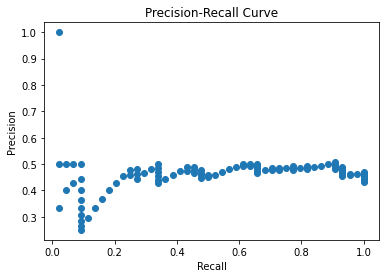

In [14]:
import matplotlib.pyplot as plt
plt.scatter(recs, precs)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
!unzip /content/20_newsgroups.zip

# Q3

In [86]:
def preprocess(line):
  '''
  Preprocess the data
    - Lowercase
    - Remove Extra Spaces
    - Lemmatize using WordNetLemmatizer()
    - Tokenize using RegexpTokenizer()
    - Remove stopwords
  '''
  line = " ".join(line.lower().split()) #lowercase and remove extra spaces
  #line = line.apply(lambda x: nltk.word_tokenize(x)) #tokenize
  line = [word for word in line.split() if not word in stopwords] #remove stopwords
  line = [lemmatizer.lemmatize(word) for word in line] #lemmatize
  line = tokenizer.tokenize(" ".join(line)) #tokenize
  return nltk.FreqDist(line)

data_dict = {}
doc_word_set = {}
class_mapping = {'comp.graphics': 0, 'sci.med': 1, 'talk.politics.misc': 2, 'rec.sport.hockey': 3, 'sci.space': 4}

for clas in class_mapping.keys():
  doc_word_set[clas] = {}
  for n, filee in enumerate(glob.glob(f'20_newsgroups/{clas}/*')):
    with open(filee, "r", encoding='windows-1254', errors='ignore') as fp:
      fp = fp.read()
      freq_dict = preprocess(fp)
    for i in freq_dict:
      if i not in data_dict:
        data_dict[i] = [([n, filee.split("/")[-1], class_mapping[clas]], freq_dict[i]/len(freq_dict))]
      else:
        data_dict[i].append(([n, filee.split("/")[-1], class_mapping[clas]], freq_dict[i]/len(freq_dict)))
    doc_word_set[clas][filee.split("/")[-1]] = set(list(freq_dict.keys()))

In [11]:
#save the index
with open('news_frequency_index.pkl', 'wb') as fp:
    pickle.dump(data_dict, fp)

In [87]:
with open('news_frequency_index.pkl', 'rb') as fp:
    data_dict = pickle.load(fp)

In [88]:
vocab = list(data_dict.keys())
tf_idf_mat = np.zeros(len(vocab))
num_classes = 5

for n, i in enumerate(list(data_dict.keys())):
    num_different_classes = len(np.unique(np.array([x[0][-1] for x in data_dict[i]])))
    num_occurences = sum([x[1] for x in data_dict[i]])
    tf_idf_mat[n] = num_occurences * np.log(num_classes/num_different_classes)

In [89]:
def eval_metrics(y_pred, y_test, binary=False, oseru_tonkachi=False):
    """
    Custom implementation to calculate metrics for for a trained model
    binary: True if data has binary labels, false otherwise
    """
    if(oseru_tonkachi):
        y_test =np.argmax(y_test, axis=1)
        y_test = np.reshape(y_test,(-1,1))
        y_pred =np.argmax(y_pred, axis=1)
        y_pred = np.reshape(y_pred,(-1,1))
    if(binary):
        accuracy = (np.sum(y_pred==y_test))/y_pred.shape[0]
        fn = np.sum((y_pred==0) & (y_test==1))
        fp = np.sum((y_pred==1) & (y_test==0))
        tn = np.sum((y_pred==0) & (y_test==0))
        tp = np.sum((y_pred==1) & (y_test==1))
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1_score = 2*tp/((2*tp)+fp+fn)
        print(tp, tn, fp, fn, " < - Positives & Negs")
        print(precision, " prec")
        print(recall, " rec")
        print(accuracy, " acc")
        print(f1_score, " f1")
    else:
        tpi = []
        tni = []
        fpi = []
        fni = []
        mac_prec = []
        mac_rec = []
        for i in np.unique(y_test):
            fn = np.sum((y_pred!=i) & (y_test==i))
            fp = np.sum((y_pred==i) & (y_test!=i))
            tn = np.sum((y_pred!=i) & (y_test!=i))
            tp = np.sum((y_pred==i) & (y_test==i))
            tpi.append(tp)
            tni.append(tn)
            fpi.append(fp)
            fni.append(fn)
            mac_prec.append(tp/(tp+fp))
            mac_rec.append(tp/(tp+fn))
        micro_precision = sum(tpi)/(sum(tpi)+sum(fpi))
        micro_recall = sum(tpi)/(sum(tpi)+sum(fni))
        micro_f1 = 2*((micro_precision*micro_recall)/(micro_precision+micro_recall))
        macro_precision = sum(mac_prec)/len(mac_prec)
        macro_recall = sum(mac_rec)/len(mac_rec)
        conf = confusion_matrix_2(y_pred, y_test)
        acc = sum([conf[i,i] for i in range(conf.shape[0])])/np.sum(conf)
        print(f"micro_precision {micro_precision}, micro_recall {micro_recall}, micro_f1 {micro_f1}, macro_precision {macro_precision}, macro_recall {macro_recall}, accuracy {acc}")
        print(conf)


def confusion_matrix_2(y_pred, y_test):
    """
    Prints confusion matrix
    """
    num_classes = np.unique(y_test)
    conf = np.zeros((len(num_classes), len(num_classes)))
    for actual in num_classes:
        for pred in num_classes:
            conf[pred, actual] = np.sum((y_pred==pred) & (y_test==actual))
    return conf

In [90]:
k = 150

class_vocab_list = {'comp.graphics': [], 'sci.med': [], 'talk.politics.misc': [], 'rec.sport.hockey': [], 'sci.space': []}

x = []
y = []
for clas in doc_word_set:
    class_word_set = set([word for doc in doc_word_set[clas] for word in doc_word_set[clas][doc]])
    tf_icf_pair = [(tf_idf_mat[vocab.index(word)], word) for word in class_word_set]
    heapq.heapify(tf_icf_pair)
    class_vocab_list[clas] = [pair[1] for pair in heapq.nlargest(k, tf_icf_pair)]

effective_vocab = list(set(class_vocab_list['comp.graphics'] + class_vocab_list['sci.med'] + class_vocab_list['talk.politics.misc'] + class_vocab_list['rec.sport.hockey'] + class_vocab_list['sci.space']))
for clas in doc_word_set:
    for doc in doc_word_set[clas]:
        feature_list = np.zeros((len(effective_vocab)))
        for word in set(doc_word_set[clas][doc]).intersection(set(class_vocab_list[clas])):
            feature_list[effective_vocab.index(word)] = tf_idf_mat[effective_vocab.index(word)]
        x.append(feature_list)
        y.append(class_mapping[clas])
        

In [91]:
x = np.array(x)
y = np.array(y)

In [92]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04411412],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04411412],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04411412],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04411412]])

In [93]:
x.shape

(5000, 479)

## 80-20 Split

In [94]:
filenames = np.array(glob.glob('20_newsgroups/comp.graphics/*') + glob.glob('20_newsgroups/sci.med/*') + glob.glob('20_newsgroups/talk.politics.misc/*') + glob.glob('20_newsgroups/rec.sport.hockey/*') + glob.glob('20_newsgroups/sci.space/*'))
train_size = 0.8

train = np.random.choice(range(filenames.shape[0]), int(train_size*filenames.shape[0]), replace=False)
test = list(set(range(filenames.shape[0])) - set(train))

X_train = x[train]
y_train = y[train]
X_test = x[test]
y_test = y[test]

In [95]:
prior_probs = {} # Prior probablities of classe
num_classes = 0     # Gets updated to number of classes
mean_std = {}       # Gets updated after training, stores mean and std dev of each feature classwise
best_class_guess = 0 # Class with highes prior probability, used during prediction

def prior(y):
    """
    Calculates Prior probabilites for classes
    """
    probs = {}
    for i in np.unique(y):
        probs[i] = np.sum(y==i)/len(y)
    return probs

def seperate_samples(X, y):
    """
    Separates the samples into classes
    """
    classes = np.unique(y)
    temp = {}
    for i in classes:
        this_class = X[np.where(y==i)[0]] # Get sample which belongs to class i
        temp[i] = this_class
    return temp

def calc_mean_std(X):
    """
    Calculate Mean and Stdev for each feature
    """
    values = []
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    values.append(means)
    values.append(stds)
    return values

def classwise_mean_std(X, y):
    """
    Calculate mean, stdev of features class wise
    returns a classwise dictionary
    """
    separated_classes = seperate_samples(X,y)
    mean_stds = []
    class_dict = {}
    for i in separated_classes:
        temp = calc_mean_std(separated_classes[i])
        class_dict[i] = temp
    return class_dict

def fit(X, y):
    """
    Wrapper to calculate classwise mean and stdev
    """
    to_ret = classwise_mean_std(X, y)
    return to_ret

def gaussian(x, mu, sigma):
    """
    Calculates the Gaussian Likelihood.
    """
    exponent = exp(-((x-mu)**2/(2*(sigma+1e-6)**2))) # Added 1e-6 for the case when sigma is 0
    return (1/(sqrt(2*pi)*(sigma+1e-6)))*exponent

def pred_helper(X):
    """
    Predicts class for each 1 x num_features sample array.
    Returns best class guess
    """
    class_guess = best_class_guess # Set to the class with max apriori probability
    best_sum = -math.inf
    for i in range(num_classes):
        temp_sum = np.log(prior_probs[i])
        for j in range(len(X)):
            adder = np.log(gaussian(X[j], mean_std[i][0][j], mean_std[i][1][j]))
            if(adder!=None):
                temp_sum+=adder
        if(temp_sum>best_sum):
            best_sum = temp_sum
            class_guess = i
    return class_guess

def predict(X):
    """
    Wrapper for pred_helper function.
    Returns predictions
    """ 
    y_pred = []
    for i in X:
        lolz = pred_helper(i)
        y_pred.append(lolz)
    return y_pred

prior_probs = prior(y)
num_classes = len(np.unique(y))
for i in prior_probs:
    if(prior_probs[i]>best_class_guess):
        best_class_guess = i
mean_std = fit(X_train,y_train)
y_pred = predict(X_test)     
print(eval_metrics(y_pred, y_test))   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


micro_precision 0.884, micro_recall 0.884, micro_f1 0.884, macro_precision 0.8977476616454594, macro_recall 0.8829267832622344, accuracy 0.884
[[170.   1.  39.   0.   2.]
 [  2. 133.   0.   1.   1.]
 [  4.   7. 166.   0.   0.]
 [  0.   0.   0. 208.   0.]
 [  3.  54.   2.   0. 207.]]
None


## 70-30

In [96]:
filenames = np.array(glob.glob('20_newsgroups/comp.graphics/*') + glob.glob('20_newsgroups/sci.med/*') + glob.glob('20_newsgroups/talk.politics.misc/*') + glob.glob('20_newsgroups/rec.sport.hockey/*') + glob.glob('20_newsgroups/sci.space/*'))
train_size = 0.7

train = np.random.choice(range(filenames.shape[0]), int(train_size*filenames.shape[0]), replace=False)
test = list(set(range(filenames.shape[0])) - set(train))

X_train = x[train]
y_train = y[train]
X_test = x[test]
y_test = y[test]

prior_probs = {} # Prior probablities of classe
num_classes = 0     # Gets updated to number of classes
mean_std = {}       # Gets updated after training, stores mean and std dev of each feature classwise
best_class_guess = 0 # Class with highes prior probability, used during prediction

def prior(y):
    """
    Calculates Prior probabilites for classes
    """
    probs = {}
    for i in np.unique(y):
        probs[i] = np.sum(y==i)/len(y)
    return probs

def seperate_samples(X, y):
    """
    Separates the samples into classes
    """
    classes = np.unique(y)
    temp = {}
    for i in classes:
        this_class = X[np.where(y==i)[0]] # Get sample which belongs to class i
        temp[i] = this_class
    return temp

def calc_mean_std(X):
    """
    Calculate Mean and Stdev for each feature
    """
    values = []
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    values.append(means)
    values.append(stds)
    return values

def classwise_mean_std(X, y):
    """
    Calculate mean, stdev of features class wise
    returns a classwise dictionary
    """
    separated_classes = seperate_samples(X,y)
    mean_stds = []
    class_dict = {}
    for i in separated_classes:
        temp = calc_mean_std(separated_classes[i])
        class_dict[i] = temp
    return class_dict

def fit(X, y):
    """
    Wrapper to calculate classwise mean and stdev
    """
    to_ret = classwise_mean_std(X, y)
    return to_ret

def gaussian(x, mu, sigma):
    """
    Calculates the Gaussian Likelihood.
    """
    exponent = exp(-((x-mu)**2/(2*(sigma+1e-6)**2))) # Added 1e-6 for the case when sigma is 0
    return (1/(sqrt(2*pi)*(sigma+1e-6)))*exponent

def pred_helper(X):
    """
    Predicts class for each 1 x num_features sample array.
    Returns best class guess
    """
    class_guess = best_class_guess # Set to the class with max apriori probability
    best_sum = -math.inf
    for i in range(num_classes):
        temp_sum = np.log(prior_probs[i])
        for j in range(len(X)):
            adder = np.log(gaussian(X[j], mean_std[i][0][j], mean_std[i][1][j]))
            if(adder!=None):
                temp_sum+=adder
        if(temp_sum>best_sum):
            best_sum = temp_sum
            class_guess = i
    return class_guess

def predict(X):
    """
    Wrapper for pred_helper function.
    Returns predictions
    """ 
    y_pred = []
    for i in X:
        lolz = pred_helper(i)
        y_pred.append(lolz)
    return y_pred

prior_probs = prior(y)
num_classes = len(np.unique(y))
for i in prior_probs:
    if(prior_probs[i]>best_class_guess):
        best_class_guess = i
mean_std = fit(X_train,y_train)
y_pred = predict(X_test)        
print(eval_metrics(y_pred, y_test))   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log


micro_precision 0.828, micro_recall 0.828, micro_f1 0.828, macro_precision 0.8673011395565181, macro_recall 0.8308409607375526, accuracy 0.828
[[189.   1.   0.   0.   4.]
 [  1. 191.   3.   2.   4.]
 [112.  24. 287.   0.   4.]
 [  0.   0.   0. 282.   0.]
 [  5.  88.  10.   0. 293.]]
None


## 50-50

In [97]:
filenames = np.array(glob.glob('20_newsgroups/comp.graphics/*') + glob.glob('20_newsgroups/sci.med/*') + glob.glob('20_newsgroups/talk.politics.misc/*') + glob.glob('20_newsgroups/rec.sport.hockey/*') + glob.glob('20_newsgroups/sci.space/*'))
train_size = 0.5

train = np.random.choice(range(filenames.shape[0]), int(train_size*filenames.shape[0]), replace=False)
test = list(set(range(filenames.shape[0])) - set(train))

X_train = x[train]
y_train = y[train]
X_test = x[test]
y_test = y[test]

prior_probs = {} # Prior probablities of classe
num_classes = 0     # Gets updated to number of classes
mean_std = {}       # Gets updated after training, stores mean and std dev of each feature classwise
best_class_guess = 0 # Class with highes prior probability, used during prediction

def prior(y):
    """
    Calculates Prior probabilites for classes
    """
    probs = {}
    for i in np.unique(y):
        probs[i] = np.sum(y==i)/len(y)
    return probs

def seperate_samples(X, y):
    """
    Separates the samples into classes
    """
    classes = np.unique(y)
    temp = {}
    for i in classes:
        this_class = X[np.where(y==i)[0]] # Get sample which belongs to class i
        temp[i] = this_class
    return temp

def calc_mean_std(X):
    """
    Calculate Mean and Stdev for each feature
    """
    values = []
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    values.append(means)
    values.append(stds)
    return values

def classwise_mean_std(X, y):
    """
    Calculate mean, stdev of features class wise
    returns a classwise dictionary
    """
    separated_classes = seperate_samples(X,y)
    mean_stds = []
    class_dict = {}
    for i in separated_classes:
        temp = calc_mean_std(separated_classes[i])
        class_dict[i] = temp
    return class_dict

def fit(X, y):
    """
    Wrapper to calculate classwise mean and stdev
    """
    to_ret = classwise_mean_std(X, y)
    return to_ret

def gaussian(x, mu, sigma):
    """
    Calculates the Gaussian Likelihood.
    """
    exponent = exp(-((x-mu)**2/(2*(sigma+1e-6)**2))) # Added 1e-6 for the case when sigma is 0
    return (1/(sqrt(2*pi)*(sigma+1e-6)))*exponent

def pred_helper(X):
    """
    Predicts class for each 1 x num_features sample array.
    Returns best class guess
    """
    class_guess = best_class_guess # Set to the class with max apriori probability
    best_sum = -math.inf
    for i in range(num_classes):
        temp_sum = np.log(prior_probs[i])
        for j in range(len(X)):
            adder = np.log(gaussian(X[j], mean_std[i][0][j], mean_std[i][1][j]))
            if(adder!=None):
                temp_sum+=adder
        if(temp_sum>best_sum):
            best_sum = temp_sum
            class_guess = i
    return class_guess

def predict(X):
    """
    Wrapper for pred_helper function.
    Returns predictions
    """ 
    y_pred = []
    for i in X:
        lolz = pred_helper(i)
        y_pred.append(lolz)
    return y_pred

prior_probs = prior(y)
num_classes = len(np.unique(y))
for i in prior_probs:
    if(prior_probs[i]>best_class_guess):
        best_class_guess = i
mean_std = fit(X_train,y_train)
y_pred = predict(X_test)        
print(eval_metrics(y_pred, y_test))   


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log


micro_precision 0.8592, micro_recall 0.8592, micro_f1 0.8592000000000001, macro_precision 0.8756760823617826, macro_recall 0.860178778556391, accuracy 0.8592
[[467.   3. 103.   0.   1.]
 [  7. 329.   4.   4.   5.]
 [  7.  33. 369.   0.   4.]
 [  0.   0.   0. 497.   0.]
 [ 21. 152.   8.   0. 486.]]
None
